In [1]:
import numpy as np
from model_vanilla_rot2d import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/rot2d_aug_argminW_lr0.0002/checkpoint"
sample_dir = "./out/rot2d_aug_argminW_lr0.0002/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

rot2d aug is disabled
loading mnist without augmenting ...
model_vanilla_rot2d ...
 [*] Reading checkpoints... ./out/rot2d_aug_argminW_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from ./out/rot2d_aug_argminW_lr0.0002/checkpoint/model.b64-327200
 [*] Success to read model.b64-327200


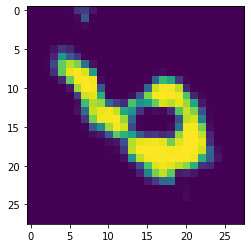

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    target_fn = np.copy(outputs_zs)
    mask_fn = np.ones(outputs_zs.shape)
#     print('rotate with alphas:', alpha)
    mask_out = np.zeros(outputs_zs.shape)

    for i in range(outputs_zs.shape[0]):
        if alpha!=0:
            M = cv2.getRotationMatrix2D((img_size//2, img_size//2), alpha, 1)
            target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
        else:
            mask_out[i,:,:,:] = mask_fn[i,:,:,:]

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)

    if show_img:
        print('Target image:')
        imshow(imgrid(np.uint8(target_fn*255), cols=4))

    if show_mask:
        print('Target mask:')
        imshow(imgrid(np.uint8(mask_out*255), cols=4))

    return target_fn, mask_out


In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/rot2d_aug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 180)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-20 15:33:02,380 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.19829463958740234, 0, 0, 0.13823814690113068, -56
2019-09-20 15:33:02,389 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007310390472412109, 0, 10, 0.12138055264949799, -174
2019-09-20 15:33:02,398 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008370399475097656, 0, 20, 0.12335128337144852, 88
2019-09-20 15:33:02,408 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008733034133911133, 0, 30, 0.11962844431400299, -38
2019-09-20 15:33:02,418 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009146451950073242, 0, 40, 0.13733358681201935, 65
2019-09-20 15:33:02,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00940561294555664, 0, 50, 0.12577565014362335, 129
2019-09-20 15:33:02,440 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00949549674987793, 0, 60, 0.10885334014892578, 149
2019-09-20 15:33:02,451 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009459257125854492, 0, 70, 0.11497768014669418, 93
2019-09-20 15:33:02,46

2019-09-20 15:33:03,112 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009488821029663086, 0, 670, 0.13762632012367249, 159
2019-09-20 15:33:03,124 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009586095809936523, 0, 680, 0.12153523415327072, 166
2019-09-20 15:33:03,135 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009359121322631836, 0, 690, 0.10489312559366226, -59
2019-09-20 15:33:03,146 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010138273239135742, 0, 700, 0.11683114618062973, -83
2019-09-20 15:33:03,157 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009602069854736328, 0, 710, 0.1134941577911377, -97
2019-09-20 15:33:03,167 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009104490280151367, 0, 720, 0.12209764122962952, -90
2019-09-20 15:33:03,178 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009195089340209961, 0, 730, 0.10687726736068726, 99
2019-09-20 15:33:03,189 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009856224060058594, 0, 740, 0.08818948268890381, -19
2019-09-20

2019-09-20 15:33:03,842 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009303092956542969, 0, 1330, 0.10316706448793411, -16
2019-09-20 15:33:03,856 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012319803237915039, 0, 1340, 0.1018512174487114, -3
2019-09-20 15:33:03,866 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00925135612487793, 0, 1350, 0.09642457962036133, 89
2019-09-20 15:33:03,877 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009757280349731445, 0, 1360, 0.11272337287664413, -132
2019-09-20 15:33:03,889 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010171890258789062, 0, 1370, 0.11367546021938324, 36
2019-09-20 15:33:03,900 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009404659271240234, 0, 1380, 0.1009567454457283, -51
2019-09-20 15:33:03,911 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009646892547607422, 0, 1390, 0.0979233905673027, 88
2019-09-20 15:33:03,922 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01009225845336914, 0, 1400, 0.12439151853322983, 136
2019-09-

2019-09-20 15:33:04,574 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00879812240600586, 0, 1990, 0.11741672456264496, 26
2019-09-20 15:33:04,585 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009398937225341797, 0, 2000, 0.11631986498832703, 116
Loss: [0.011324579864740371, 0.01057041284441948]
2019-09-20 15:33:04,597 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009860992431640625, 0, 2010, 0.11841680854558945, 21
2019-09-20 15:33:04,607 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009155035018920898, 0, 2020, 0.11036385595798492, -151
2019-09-20 15:33:04,617 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009068012237548828, 0, 2030, 0.12090761959552765, -61
2019-09-20 15:33:04,628 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009414196014404297, 0, 2040, 0.09741997718811035, -2
2019-09-20 15:33:04,639 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00933837890625, 0, 2050, 0.10262003540992737, 154
2019-09-20 15:33:04,649 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00907278060

2019-09-20 15:33:05,256 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007648944854736328, 0, 2650, 0.10518687218427658, -64
2019-09-20 15:33:05,264 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007246971130371094, 0, 2660, 0.13333731889724731, 109
2019-09-20 15:33:05,273 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0075910091400146484, 0, 2670, 0.08584289252758026, 74
2019-09-20 15:33:05,282 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008617877960205078, 0, 2680, 0.14135685563087463, 146
2019-09-20 15:33:05,294 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010088205337524414, 0, 2690, 0.08158250898122787, -23
2019-09-20 15:33:05,304 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009130477905273438, 0, 2700, 0.11900760233402252, 50
2019-09-20 15:33:05,314 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00872659683227539, 0, 2710, 0.12599870562553406, -157
2019-09-20 15:33:05,328 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012273788452148438, 0, 2720, 0.12038005143404007, 114
2

2019-09-20 15:33:06,008 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00985264778137207, 0, 3310, 0.08260048180818558, -80
2019-09-20 15:33:06,022 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012724161148071289, 0, 3320, 0.09910865128040314, 66
2019-09-20 15:33:06,035 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011045694351196289, 0, 3330, 0.11078286170959473, -142
2019-09-20 15:33:06,046 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009818077087402344, 0, 3340, 0.1044081300497055, 20
2019-09-20 15:33:06,057 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009685039520263672, 0, 3350, 0.10968640446662903, -149
2019-09-20 15:33:06,069 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010428905487060547, 0, 3360, 0.10774875432252884, -169
2019-09-20 15:33:06,080 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009789466857910156, 0, 3370, 0.12355653941631317, -43
2019-09-20 15:33:06,091 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00967097282409668, 0, 3380, 0.09695065766572952, 93
201

2019-09-20 15:33:06,751 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009505748748779297, 0, 3970, 0.09724745154380798, 119
2019-09-20 15:33:06,763 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009804487228393555, 0, 3980, 0.11453050374984741, -125
2019-09-20 15:33:06,774 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009999752044677734, 0, 3990, 0.11436770856380463, -107
2019-09-20 15:33:06,786 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01053309440612793, 0, 4000, 0.1153566911816597, 48
Loss: [0.011324579864740371, 0.01057041284441948, 0.010533928345888854, 0.010631065011024475]
2019-09-20 15:33:06,801 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01335287094116211, 0, 4010, 0.0948759987950325, -55
2019-09-20 15:33:06,812 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009423017501831055, 0, 4020, 0.11442235857248306, -148
2019-09-20 15:33:06,823 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009910821914672852, 0, 4030, 0.08967222273349762, -88
2019-09-20 15:33:06,834 [MainThre

2019-09-20 15:33:07,505 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009526252746582031, 0, 4630, 0.11805718392133713, 128
2019-09-20 15:33:07,516 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009806156158447266, 0, 4640, 0.09374195337295532, 38
2019-09-20 15:33:07,527 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009559154510498047, 0, 4650, 0.10412479937076569, -19
2019-09-20 15:33:07,538 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010005712509155273, 0, 4660, 0.10864437371492386, 153
2019-09-20 15:33:07,549 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009803056716918945, 0, 4670, 0.09413792937994003, -16
2019-09-20 15:33:07,560 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009742021560668945, 0, 4680, 0.10484035313129425, -29
2019-09-20 15:33:07,571 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009806632995605469, 0, 4690, 0.12103848159313202, 18
2019-09-20 15:33:07,583 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009768247604370117, 0, 4700, 0.09693041443824768, 133
20

2019-09-20 15:33:08,256 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010717391967773438, 0, 5280, 0.0945153683423996, 6
2019-09-20 15:33:08,270 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013575077056884766, 0, 5290, 0.10358145087957382, -55
2019-09-20 15:33:08,281 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009042501449584961, 0, 5300, 0.08782286942005157, -162
2019-09-20 15:33:08,291 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009377241134643555, 0, 5310, 0.11958419531583786, 41
2019-09-20 15:33:08,303 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010059356689453125, 0, 5320, 0.10931581258773804, -133
2019-09-20 15:33:08,318 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014157772064208984, 0, 5330, 0.10807254165410995, 48
2019-09-20 15:33:08,328 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00918722152709961, 0, 5340, 0.11058717966079712, 145
2019-09-20 15:33:08,339 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009026288986206055, 0, 5350, 0.0980287566781044, -6
2019-0

2019-09-20 15:33:09,020 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009839773178100586, 0, 5940, 0.08118795603513718, 5
2019-09-20 15:33:09,030 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00915384292602539, 0, 5950, 0.07310211658477783, 1
2019-09-20 15:33:09,041 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009815454483032227, 0, 5960, 0.12206152826547623, 35
2019-09-20 15:33:09,052 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009524106979370117, 0, 5970, 0.12958954274654388, -22
2019-09-20 15:33:09,064 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010455608367919922, 0, 5980, 0.10814663767814636, -165
2019-09-20 15:33:09,077 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010679960250854492, 0, 5990, 0.12216939777135849, -150
2019-09-20 15:33:09,088 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010131120681762695, 0, 6000, 0.10079187899827957, 76
Loss: [0.011324579864740371, 0.01057041284441948, 0.010533928345888854, 0.010631065011024475, 0.010543898321688176, 0.010398549228

2019-09-20 15:33:09,757 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015674114227294922, 0, 6590, 0.11842493712902069, 158
2019-09-20 15:33:09,767 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009159326553344727, 0, 6600, 0.10006745159626007, 118
2019-09-20 15:33:09,778 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009654521942138672, 0, 6610, 0.11211435496807098, -124
2019-09-20 15:33:09,790 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010546207427978516, 0, 6620, 0.09175670146942139, 17
2019-09-20 15:33:09,805 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013434410095214844, 0, 6630, 0.11910837143659592, -64
2019-09-20 15:33:09,815 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009119033813476562, 0, 6640, 0.1014334112405777, 172
2019-09-20 15:33:09,826 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009425163269042969, 0, 6650, 0.09701570123434067, -91
2019-09-20 15:33:09,836 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009068965911865234, 0, 6660, 0.12323666363954544, -168


2019-09-20 15:33:10,486 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009448051452636719, 0, 7240, 0.09367585927248001, 50
2019-09-20 15:33:10,506 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01796102523803711, 0, 7250, 0.08833629637956619, -68
2019-09-20 15:33:10,517 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009683370590209961, 0, 7260, 0.07639512419700623, 23
2019-09-20 15:33:10,527 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009174346923828125, 0, 7270, 0.09604249894618988, 75
2019-09-20 15:33:10,538 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009453773498535156, 0, 7280, 0.13766182959079742, -146
2019-09-20 15:33:10,548 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009020566940307617, 0, 7290, 0.08304912596940994, -86
2019-09-20 15:33:10,559 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009080648422241211, 0, 7300, 0.10153181850910187, -106
2019-09-20 15:33:10,569 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009163379669189453, 0, 7310, 0.10424677282571793, 37
201

2019-09-20 15:33:11,193 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008840084075927734, 0, 7900, 0.09907275438308716, -115
2019-09-20 15:33:11,204 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009161949157714844, 0, 7910, 0.09790365397930145, 105
2019-09-20 15:33:11,214 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009128093719482422, 0, 7920, 0.1319882571697235, 43
2019-09-20 15:33:11,224 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009142160415649414, 0, 7930, 0.09387402981519699, 61
2019-09-20 15:33:11,237 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011758804321289062, 0, 7940, 0.09332934767007828, -154
2019-09-20 15:33:11,248 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008932352066040039, 0, 7950, 0.12332451343536377, 175
2019-09-20 15:33:11,259 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00944209098815918, 0, 7960, 0.09630187600851059, -142
2019-09-20 15:33:11,269 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009485483169555664, 0, 7970, 0.10725241899490356, 22
20

2019-09-20 15:33:11,896 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009380102157592773, 0, 8550, 0.09297066926956177, 19
2019-09-20 15:33:11,907 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009511947631835938, 0, 8560, 0.10706328600645065, 179
2019-09-20 15:33:11,918 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009057283401489258, 0, 8570, 0.09268176555633545, 79
2019-09-20 15:33:11,928 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009093523025512695, 0, 8580, 0.0958288386464119, 102
2019-09-20 15:33:11,939 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0090484619140625, 0, 8590, 0.09339522570371628, -99
2019-09-20 15:33:11,950 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00920248031616211, 0, 8600, 0.0963626578450203, -107
2019-09-20 15:33:11,961 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009733200073242188, 0, 8610, 0.11185649782419205, 153
2019-09-20 15:33:11,972 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009051084518432617, 0, 8620, 0.10413103550672531, -126
2019-

2019-09-20 15:33:12,608 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009344100952148438, 0, 9200, 0.09381581097841263, 102
2019-09-20 15:33:12,619 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009378910064697266, 0, 9210, 0.1012059897184372, 41
2019-09-20 15:33:12,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009258270263671875, 0, 9220, 0.08361585438251495, -167
2019-09-20 15:33:12,641 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009513378143310547, 0, 9230, 0.08382118493318558, -171
2019-09-20 15:33:12,652 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009058475494384766, 0, 9240, 0.06264764815568924, -1
2019-09-20 15:33:12,663 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009333133697509766, 0, 9250, 0.09633578360080719, 123
2019-09-20 15:33:12,673 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009163856506347656, 0, 9260, 0.09539490938186646, -32
2019-09-20 15:33:12,684 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009071588516235352, 0, 9270, 0.11757542192935944, 22
20

2019-09-20 15:33:13,353 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009299993515014648, 0, 9860, 0.0991380363702774, 146
2019-09-20 15:33:13,365 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009783029556274414, 0, 9870, 0.08964400738477707, 78
2019-09-20 15:33:13,376 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009434700012207031, 0, 9880, 0.11293607205152512, 114
2019-09-20 15:33:13,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009328365325927734, 0, 9890, 0.10250524431467056, -174
2019-09-20 15:33:13,398 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010459423065185547, 0, 9900, 0.12201607972383499, 129
2019-09-20 15:33:13,411 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01122283935546875, 0, 9910, 0.12102542817592621, 146
2019-09-20 15:33:13,423 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010567426681518555, 0, 9920, 0.09391287714242935, 78
2019-09-20 15:33:13,434 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009027957916259766, 0, 9930, 0.10525544732809067, 106
201

2019-09-20 15:33:14,075 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009989023208618164, 0, 10500, 0.09800025820732117, -107
2019-09-20 15:33:14,086 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010320663452148438, 0, 10510, 0.09436871111392975, 149
2019-09-20 15:33:14,098 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009858131408691406, 0, 10520, 0.08427760750055313, -168
2019-09-20 15:33:14,109 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009793758392333984, 0, 10530, 0.09623784571886063, 101
2019-09-20 15:33:14,120 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009258508682250977, 0, 10540, 0.10712701082229614, 28
2019-09-20 15:33:14,131 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009475231170654297, 0, 10550, 0.11177350580692291, 52
2019-09-20 15:33:14,142 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009764909744262695, 0, 10560, 0.1287931650876999, 146
2019-09-20 15:33:14,153 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009348392486572266, 0, 10570, 0.1066415235400199

2019-09-20 15:33:14,791 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009243011474609375, 0, 11140, 0.10508111864328384, -25
2019-09-20 15:33:14,801 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00894784927368164, 0, 11150, 0.09368440508842468, 121
2019-09-20 15:33:14,812 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009182214736938477, 0, 11160, 0.12296382337808609, 165
2019-09-20 15:33:14,824 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009482383728027344, 0, 11170, 0.09906593710184097, 22
2019-09-20 15:33:14,835 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009788036346435547, 0, 11180, 0.08339861780405045, 32
2019-09-20 15:33:14,847 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010175228118896484, 0, 11190, 0.09825897216796875, -157
2019-09-20 15:33:14,858 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009550333023071289, 0, 11200, 0.0881299078464508, -76
2019-09-20 15:33:14,868 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00933074951171875, 0, 11210, 0.11262331157922745, 

2019-09-20 15:33:15,486 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009752273559570312, 0, 11800, 0.13329735398292542, -121
2019-09-20 15:33:15,496 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009344100952148438, 0, 11810, 0.08362922072410583, -80
2019-09-20 15:33:15,507 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009063005447387695, 0, 11820, 0.09822820872068405, -153
2019-09-20 15:33:15,518 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009142637252807617, 0, 11830, 0.08859443664550781, 146
2019-09-20 15:33:15,529 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009418010711669922, 0, 11840, 0.07958070933818817, 82
2019-09-20 15:33:15,539 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009223461151123047, 0, 11850, 0.09239703416824341, -40
2019-09-20 15:33:15,550 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009031295776367188, 0, 11860, 0.10063163191080093, 149
2019-09-20 15:33:15,561 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009638071060180664, 0, 11870, 0.11010606586933

2019-09-20 15:33:16,203 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009249210357666016, 0, 12440, 0.10902351886034012, -166
2019-09-20 15:33:16,213 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009313821792602539, 0, 12450, 0.10266995429992676, -43
2019-09-20 15:33:16,224 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009100914001464844, 0, 12460, 0.0751175805926323, 15
2019-09-20 15:33:16,236 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010059356689453125, 0, 12470, 0.09442796558141708, 109
2019-09-20 15:33:16,246 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009020328521728516, 0, 12480, 0.10054180771112442, -39
2019-09-20 15:33:16,258 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009869575500488281, 0, 12490, 0.0940505862236023, -165
2019-09-20 15:33:16,268 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00926065444946289, 0, 12500, 0.1062425971031189, 33
2019-09-20 15:33:16,280 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009803056716918945, 0, 12510, 0.10773499310016632, 

2019-09-20 15:33:16,894 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009290218353271484, 0, 13070, 0.1011022999882698, -50
2019-09-20 15:33:16,904 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009329557418823242, 0, 13080, 0.1163194328546524, 113
2019-09-20 15:33:16,916 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010594844818115234, 0, 13090, 0.09162958711385727, 119
2019-09-20 15:33:16,927 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009862184524536133, 0, 13100, 0.07744207233190536, -128
2019-09-20 15:33:16,938 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009302616119384766, 0, 13110, 0.08561518788337708, 18
2019-09-20 15:33:16,953 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01424098014831543, 0, 13120, 0.10701475292444229, -12
2019-09-20 15:33:16,965 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01001882553100586, 0, 13130, 0.08901705592870712, -170
2019-09-20 15:33:16,975 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009336471557617188, 0, 13140, 0.10897886008024216,

2019-09-20 15:33:17,608 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009135961532592773, 0, 13730, 0.07702717185020447, -104
2019-09-20 15:33:17,620 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010265827178955078, 0, 13740, 0.10212477296590805, 163
2019-09-20 15:33:17,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009837865829467773, 0, 13750, 0.09635183215141296, -108
2019-09-20 15:33:17,642 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009629249572753906, 0, 13760, 0.08934177458286285, 16
2019-09-20 15:33:17,652 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008922576904296875, 0, 13770, 0.11349093168973923, -91
2019-09-20 15:33:17,663 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009453058242797852, 0, 13780, 0.10154157131910324, -103
2019-09-20 15:33:17,674 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009320497512817383, 0, 13790, 0.10849861055612564, 118
2019-09-20 15:33:17,685 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010010957717895508, 0, 13800, 0.0873211547732

2019-09-20 15:33:18,309 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009966850280761719, 0, 14360, 0.11632651090621948, -22
2019-09-20 15:33:18,320 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009940385818481445, 0, 14370, 0.10637371242046356, 113
2019-09-20 15:33:18,331 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009872198104858398, 0, 14380, 0.10770954936742783, 69
2019-09-20 15:33:18,343 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010309696197509766, 0, 14390, 0.10511250048875809, -108
2019-09-20 15:33:18,355 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010835886001586914, 0, 14400, 0.09254924952983856, 162
2019-09-20 15:33:18,366 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00991964340209961, 0, 14410, 0.11075147241353989, -132
2019-09-20 15:33:18,377 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010000467300415039, 0, 14420, 0.09880052506923676, -27
2019-09-20 15:33:18,389 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010410785675048828, 0, 14430, 0.097464755177497

2019-09-20 15:33:19,049 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010786056518554688, 0, 15010, 0.10134399682283401, -12
2019-09-20 15:33:19,060 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009434223175048828, 0, 15020, 0.099472276866436, 66
2019-09-20 15:33:19,071 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009567975997924805, 0, 15030, 0.11409176141023636, -119
2019-09-20 15:33:19,082 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009579658508300781, 0, 15040, 0.07223521918058395, -21
2019-09-20 15:33:19,094 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010079383850097656, 0, 15050, 0.10493400692939758, -17
2019-09-20 15:33:19,106 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010170936584472656, 0, 15060, 0.09942904114723206, 64
2019-09-20 15:33:19,117 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010077714920043945, 0, 15070, 0.08489544689655304, -174
2019-09-20 15:33:19,128 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009330987930297852, 0, 15080, 0.09562478959560394

2019-09-20 15:33:19,783 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009573936462402344, 0, 15670, 0.07643269747495651, 85
2019-09-20 15:33:19,794 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010080575942993164, 0, 15680, 0.11309020966291428, 42
2019-09-20 15:33:19,805 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009889602661132812, 0, 15690, 0.10077731311321259, 71
2019-09-20 15:33:19,817 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01004481315612793, 0, 15700, 0.10824496299028397, 156
2019-09-20 15:33:19,828 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009387969970703125, 0, 15710, 0.11070580035448074, -154
2019-09-20 15:33:19,839 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009518623352050781, 0, 15720, 0.1548072099685669, -148
2019-09-20 15:33:19,849 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009551286697387695, 0, 15730, 0.13292713463306427, -43
2019-09-20 15:33:19,861 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00982809066772461, 0, 15740, 0.10365034639835358, 

2019-09-20 15:33:20,498 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009493827819824219, 0, 16300, 0.10743952542543411, 113
2019-09-20 15:33:20,509 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009328365325927734, 0, 16310, 0.08634407818317413, -130
2019-09-20 15:33:20,520 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010143756866455078, 0, 16320, 0.08723130077123642, 36
2019-09-20 15:33:20,532 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009495258331298828, 0, 16330, 0.1060909703373909, 74
2019-09-20 15:33:20,542 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009501457214355469, 0, 16340, 0.08968199044466019, -10
2019-09-20 15:33:20,554 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009851932525634766, 0, 16350, 0.1047927513718605, -168
2019-09-20 15:33:20,565 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00970911979675293, 0, 16360, 0.09231090545654297, 7
2019-09-20 15:33:20,576 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010131359100341797, 0, 16370, 0.10316510498523712, -

2019-09-20 15:33:21,226 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009432315826416016, 0, 16960, 0.11659780889749527, -92
2019-09-20 15:33:21,237 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009986400604248047, 0, 16970, 0.11993285268545151, 131
2019-09-20 15:33:21,249 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01025390625, 0, 16980, 0.0827803686261177, 84
2019-09-20 15:33:21,260 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009643793106079102, 0, 16990, 0.11853069067001343, -103
2019-09-20 15:33:21,271 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00988912582397461, 0, 17000, 0.09972231835126877, -75
Loss: [0.011324579864740371, 0.01057041284441948, 0.010533928345888854, 0.010631065011024475, 0.010543898321688176, 0.010398549228906631, 0.010109967589378356, 0.01047600132972002, 0.010375243108719588, 0.010252959117293358, 0.010237896211445332, 0.009915241375565528, 0.010128428783267737, 0.010089750356972217, 0.010078687272965908, 0.009991043142974377, 0.010139273691922426]


2019-09-20 15:33:21,935 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00963282585144043, 0, 17590, 0.10770979523658752, -102
2019-09-20 15:33:21,946 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009195327758789062, 0, 17600, 0.06088273227214813, -1
2019-09-20 15:33:21,957 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00914311408996582, 0, 17610, 0.09090949594974518, -131
2019-09-20 15:33:21,968 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009376049041748047, 0, 17620, 0.09317842125892639, 96
2019-09-20 15:33:21,979 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010068178176879883, 0, 17630, 0.10424311459064484, -167
2019-09-20 15:33:21,990 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010004758834838867, 0, 17640, 0.10298927873373032, -81
2019-09-20 15:33:22,001 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009721040725708008, 0, 17650, 0.0971289575099945, -143
2019-09-20 15:33:22,012 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009430408477783203, 0, 17660, 0.0957649201154708

2019-09-20 15:33:22,637 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009429931640625, 0, 18220, 0.09446102380752563, -137
2019-09-20 15:33:22,648 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009458065032958984, 0, 18230, 0.1101188063621521, -43
2019-09-20 15:33:22,659 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009373188018798828, 0, 18240, 0.10831641405820847, 42
2019-09-20 15:33:22,670 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009186744689941406, 0, 18250, 0.08255819976329803, -59
2019-09-20 15:33:22,681 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009200334548950195, 0, 18260, 0.08905552327632904, 141
2019-09-20 15:33:22,691 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008846759796142578, 0, 18270, 0.11517341434955597, 135
2019-09-20 15:33:22,702 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009328842163085938, 0, 18280, 0.10744437575340271, -9
2019-09-20 15:33:22,712 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009221076965332031, 0, 18290, 0.09705743938684464, 4

2019-09-20 15:33:23,363 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008800745010375977, 0, 18880, 0.10584364086389542, 69
2019-09-20 15:33:23,373 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009192466735839844, 0, 18890, 0.09891899675130844, 16
2019-09-20 15:33:23,384 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009293794631958008, 0, 18900, 0.12029995024204254, -107
2019-09-20 15:33:23,394 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009159326553344727, 0, 18910, 0.09237784147262573, -99
2019-09-20 15:33:23,404 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009232759475708008, 0, 18920, 0.11854525655508041, 111
2019-09-20 15:33:23,415 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009757280349731445, 0, 18930, 0.10260843485593796, 75
2019-09-20 15:33:23,426 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009744405746459961, 0, 18940, 0.07425365597009659, 81
2019-09-20 15:33:23,437 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00959920883178711, 0, 18950, 0.0891629308462143, -

2019-09-20 15:33:24,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013027429580688477, 0, 19500, 0.1156732589006424, -120
2019-09-20 15:33:24,039 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010471105575561523, 0, 19510, 0.09542262554168701, -136
2019-09-20 15:33:24,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009119987487792969, 0, 19520, 0.08138813823461533, -13
2019-09-20 15:33:24,060 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00933837890625, 0, 19530, 0.11630416661500931, 99
2019-09-20 15:33:24,070 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008873701095581055, 0, 19540, 0.10889572650194168, -31
2019-09-20 15:33:24,081 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009689092636108398, 0, 19550, 0.12214571982622147, 48
2019-09-20 15:33:24,092 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009421586990356445, 0, 19560, 0.0889669805765152, 64
2019-09-20 15:33:24,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009856224060058594, 0, 19570, 0.10785085707902908, -31

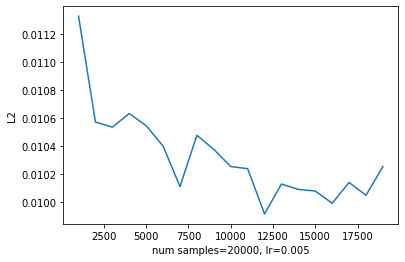

[0.011324579864740371, 0.01057041284441948, 0.010533928345888854, 0.010631065011024475, 0.010543898321688176, 0.010398549228906631, 0.010109967589378356, 0.01047600132972002, 0.010375243108719588, 0.010252959117293358, 0.010237896211445332, 0.009915241375565528, 0.010128428783267737, 0.010089750356972217, 0.010078687272965908, 0.009991043142974377, 0.010139273691922426, 0.010047882877290248, 0.010252479657530785]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[-180. -144. -108.  -72.  -36.    0.   36.   72.  108.  144.  180.]


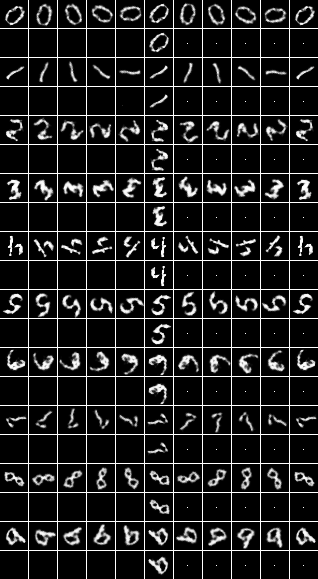

In [16]:
num_samples = 10

a = np.linspace(-180,180, 11)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -162.00, dist 0.00 +/- 0.00
alpha: -126.00, dist 0.00 +/- 0.00
alpha: -90.00, dist 0.00 +/- 0.00
alpha: -54.00, dist 0.00 +/- 0.00
alpha: -18.00, dist 0.10 +/- 0.04
alpha: 18.00, dist 0.10 +/- 0.04
alpha: 54.00, dist 0.00 +/- 0.00
alpha: 90.00, dist 0.00 +/- 0.00
alpha: 126.00, dist 0.00 +/- 0.00
alpha: 162.00, dist 0.00 +/- 0.00
2019-09-20 15:35:27,955 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-20 15:35:27,958 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


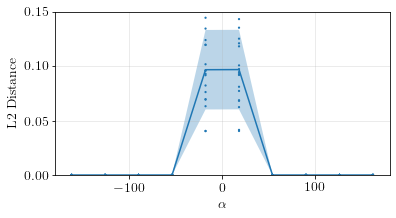

In [21]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/plots/'
savefile = 'rot2d_aug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -180.00, dist 0.10 +/- 0.01
alpha: -144.00, dist 0.11 +/- 0.01
alpha: -108.00, dist 0.10 +/- 0.01
alpha: -72.00, dist 0.10 +/- 0.01
alpha: -36.00, dist 0.10 +/- 0.01
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 36.00, dist 0.10 +/- 0.01
alpha: 72.00, dist 0.10 +/- 0.01
alpha: 108.00, dist 0.10 +/- 0.01
alpha: 144.00, dist 0.11 +/- 0.01
alpha: 180.00, dist 0.10 +/- 0.01


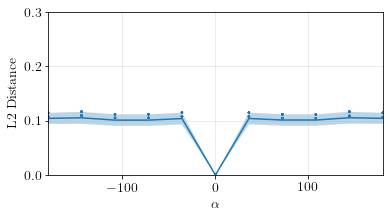

In [22]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/plots/'
savefile = 'rot2d_aug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)